In [1]:
import os
import requests
import pandas as pd
import json
from datetime import datetime, timedelta
import time
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress
import statsmodels.api as sm

# Feature Engineering

In [5]:
frame=pd.read_csv('../FullData/totaldataset.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


All the dataprocessing functions for the initial transaction data

In [10]:
def strpDateTime(data):
    return data['trx_timestamp'].apply(lambda x : datetime.strptime(x[:10]+x[11:19],"%Y-%m-%d%H:%M:%S"))
def dropCols(data):
    #d_memo and maybe block_num may have some relevance later on
    return data.drop(['account_action_seq','block_num','d_memo','authorization','global_action_seq','data','name','trx_id','trx_timestamp_unix'],axis=1)
def applyLabels(data):
    list_bots=['edgarwinston','Griffinhamza','jacksonjimmy','1ffyqhg4rmbk','1ffyqhg4rmbk','powellernest','2rezoaf4bhly','nckj42dit5sb','scottphillip','oepa252sdx4p','myh2o4wayvxg']
    list_humans=['g44dinjygene','onebrother11','rvrkingfishr','iloveyoudapp','huiyong12345','pketothemoon','zhshj1212123','vipgamedice2','dldldldldldl','pkeniubixxxx']
    data['bot_label']=data['d_from'].apply(lambda x: 1 if x in list_bots else (0 if x in list_humans else None))
def dataProcess(data):
    data['trx_timestamp']=strpDateTime(data)
    data['hours']=[i.hour for i in data['trx_timestamp']]
    data['minutes']=[i.minute for i in data['trx_timestamp']]
    data['seconds']=[i.second for i in data['trx_timestamp']]
    data['day']=[i.day for i in data['trx_timestamp']]
    applyLabels(data)
    return dropCols(data)

Functions below are all used for feature engineering. Features were decided by previous EDA and understanding of data.

In [11]:
def timeseries_daily_agg(data):
    '''
    Pulling together all data on an daily basis and applying count_txns and volume_eos to it
    @params:
    data is the transaction data set
    
    
    '''
    daily_index=pd.date_range(start="3/1/2019", end="4/1/2019", freq="D")
    timeseries_dummy = pd.DataFrame(0, index=daily_index, columns=['count_txns', 'volume_eos'])
    timeseries_dummy=timeseries_dummy.astype(float)
    for index, row in data.iterrows(): 
        time=row['trx_timestamp'].replace(microsecond=0, second=0, minute=0,hour=0)
        timeseries_dummy.loc[time]['count_txns']=1+timeseries_dummy.loc[time]['count_txns']
        timeseries_dummy.loc[time]['volume_eos']=row['d_quantity']+ timeseries_dummy.loc[time]['volume_eos']
    return timeseries_dummy
    

In [12]:
def timeseries_hourly_agg(data):
    '''
    Pulling together all data on an hourly basis and applying count_txns and volume_eos to it
    @params:
    data is the transaction data set
    
    
    '''
    hour_index=pd.date_range(start="3/1/2019", end="4/1/2019", freq="H")
    timeseries_dummy = pd.DataFrame(0, index=hour_index, columns=['count_txns', 'volume_eos'])
    timeseries_dummy=timeseries_dummy.astype(float)
    for index, row in data.iterrows(): 
        time=row['trx_timestamp'].replace(microsecond=0, second=0, minute=0)
        timeseries_dummy.loc[time]['count_txns']=1+timeseries_dummy.loc[time]['count_txns']
        timeseries_dummy.loc[time]['volume_eos']=row['d_quantity']+ timeseries_dummy.loc[time]['volume_eos']
    return timeseries_dummy

In [14]:
def maxAutoCorrelation(data,user):
    '''
    Returns a tuple with maxAutoCorrelation and lag period as values
    '''
    maxAuto=0
    l=0
    data=timeseries_hourly_agg(data[data['d_from']==user])
    
    
    for i in range(1,168):
        check=data['count_txns'].autocorr(lag=i)
        if (check > maxAuto):
            maxAuto=check
            l=i
    
    return ((maxAuto,l))

In [15]:
def countTotalTransactions(data,account_name):
    return data[data['d_from']==account_name].shape[0]

In [16]:
def getSubSetData(data,low,high):
    user_counts = data['d_from'].value_counts().rename('user_counts')

    zip_data_df = data.merge(user_counts.to_frame(),
                                left_on='d_from',
                                right_index=True)
    return zip_data_df[(zip_data_df['user_counts']>low) & (zip_data_df['user_counts']<high)]

In [17]:
def stdevVolumeSent(data,user):
    '''
    Returns a value of the standard deviation of volume of EOS sent
    '''
    hold=0
    l=0
    return np.std([x for x in data[data['d_from']==user]['d_quantity'].tolist()])

In [18]:
def daily_agg_features(data,user):
    '''
    Returns daily features
    '''
    data=data[data['d_from']==user]
    agg_df=timeseries_daily_agg(data)
    numActiveDays=agg_df['count_txns'].astype(bool).sum(axis=0)
    maxTxnsDay=max(agg_df['count_txns'])
    minTxnsDay=min(agg_df['count_txns'])
    
    avgTxnsPerActiveDays=sum(agg_df['count_txns'])/numActiveDays
    
    #getting the number of txns on weekdays vs. the number on weekends
    numTxnsWeekdays=sum(agg_df[agg_df.index.get_level_values(0).weekday<5]['count_txns'])
    numTxnsWeekends=sum(agg_df[agg_df.index.get_level_values(0).weekday>5]['count_txns'])
    
    numActiveDaysWeekdays=agg_df[agg_df.index.get_level_values(0).weekday<5]['count_txns'].astype(bool).sum(axis=0)
    numActiveDaysWeekends=agg_df[agg_df.index.get_level_values(0).weekday>5]['count_txns'].astype(bool).sum(axis=0)
    
    return (numActiveDays,maxTxnsDay,minTxnsDay,avgTxnsPerActiveDays,numTxnsWeekdays,numTxnsWeekends,numActiveDaysWeekdays,numActiveDaysWeekends)
    
    

In [19]:
def hourly_agg_features(data,user):
    '''
    Returns hourly features
    '''
    maxAuto=0
    l=0
    agg_df=timeseries_hourly_agg(data[data['d_from']==user])
    for i in range(1,168):
        check=agg_df['count_txns'].autocorr(lag=i)
        if (check > maxAuto):
            maxAuto=check
            #the lag period with the maxAutoCorr
            l=i

    numofTxns=sum(agg_df['count_txns'])
    
    #of active hours
    numActiveHours=agg_df['count_txns'].astype(bool).sum(axis=0)
    
    maxTxnsHour=max(agg_df['count_txns'])
    minTxnsHour=min(agg_df['count_txns'])
    
    txnsPerActiveHour=numofTxns/numActiveHours
    
    numActiveHoursWeekdays=agg_df[agg_df.index.get_level_values(0).weekday<5]['count_txns'].astype(bool).sum(axis=0)
    numActiveHoursWeekends=agg_df[agg_df.index.get_level_values(0).weekday>5]['count_txns'].astype(bool).sum(axis=0)
    
    return ((maxAuto,l),numActiveHours,maxTxnsHour,minTxnsHour,txnsPerActiveHour,numActiveHoursWeekdays,numActiveHoursWeekends)

In [20]:
def accountAgg(data):
    '''Final feature engineering function. That will create 17 features for machine learning
    @params data: pre-processed dataframe of transaction data
    '''
    list_accounts=data['d_from'].unique()
    dic={}
    dic={el:[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] for el in list_accounts}
    for key in dic.keys():
        
        hourly_features=hourly_agg_features(data,key)
        
        dic[key][0]=hourly_features[0][0]
        dic[key][1]=countTotalTransactions(data,key)
        dic[key][2]=stdevVolumeSent(data,key)
        
        #daily aggregation features
        daily=daily_agg_features(data,key)
        dic[key][3]=daily[0]
        dic[key][4]=daily[1]
        dic[key][5]=daily[2]
        dic[key][6]=daily[3]
        dic[key][7]=daily[4]
        dic[key][8]=daily[5]
        dic[key][9]=daily[6]
        dic[key][10]=daily[7]
        
        #other hourly features
        dic[key][11]=hourly_features[1]
        dic[key][12]=hourly_features[2]
        dic[key][13]=hourly_features[3]
        dic[key][14]=hourly_features[4]
        dic[key][15]=hourly_features[5]
        dic[key][16]=hourly_features[6]
        
    
    return pd.DataFrame.from_dict(dic,orient='index',columns=['maxAutoCorrelation','numberofTxns','stDevEosSent','numActiveDays','maxTxnsDay','minTxnsDay','avgTxnsPerActiveDays','numTxnsWeekdays','numTxnsWeekends','numActiveDaysWeekdays','numActiveWeekends','numActiveHours','maxTxnsHour','minTxnsHour','txnsPerActiveHour','numActiveHoursWeekdays','numActiveHoursWeekends']).reset_index()
    

First let's process our transaction data to prepare it for feature  engineering

In [21]:
clean_frame=dataProcess(frame)

In [22]:
clean_frame

,account,d_from,d_quantity,d_quantity_unit,d_to,dapp_code,trx_timestamp,hours,minutes,seconds,day,bot_label
0,eosio.token,justiceariel,0.1000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:02,0,0,2,7,NaN
1,eosio.token,eossuperplay,0.1000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:03,0,0,3,7,NaN
2,eosio.token,nmslnmslnmsl,0.2000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:04,0,0,4,7,NaN
3,eosio.token,edgarwinston,0.1000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:06,0,0,6,7,1.0
4,eosio.token,raidenkeegan,0.1000,EOS,endlessdicex,Endless Dice,2019-03-07 00:00:09,0,0,9,7,NaN
5,eosio.token,endlessdicex,0.0980,EOS,endlessbank1,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN
6,eosio.token,endlessdicex,0.0008,EOS,endlessdivdn,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN
7,eosio.token,endlessdicex,0.0012,EOS,endlessoptex,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN
8,eosio.token,endlessdicex,0.0980,EOS,endlessbank1,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN
9,eosio.token,endlessdicex,0.0008,EOS,endlessdivdn,Endless Dice,2019-03-07 00:00:11,0,0,11,7,NaN


Now let's begin the feature engineering!

In [102]:
data=accountAgg(getSubSetData(clean_frame,30,200))

In [103]:
data.to_csv('../Data/clusteringDataSet1.csv')

In [48]:
data=pd.read_csv('../Data/clusteringDataSet1.csv')

In [49]:
data

,Unnamed: 0,index,maxAutoCorrelation,numberofTxns,stDevEosSent,numActiveDays,maxTxnsDay,minTxnsDay,avgTxnsPerActiveDays,numTxnsWeekdays,numTxnsWeekends,numActiveDaysWeekdays,numActiveWeekends,numActiveHours,maxTxnsHour,minTxnsHour,txnsPerActiveHour,numActiveHoursWeekdays,numActiveHoursWeekends
0,0,edgarwinston,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
1,1,raidenkeegan,0.579704,41,3.864911e-01,31,11.0,0.0,1.322581,21.0,15.0,21,5,31,11.0,0.0,1.322581,21,5
2,2,heathderrick,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
3,3,jakobantoine,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
4,4,bryantjaylon,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
5,5,karsonskylar,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
6,6,luisclarence,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
7,7,griffinhamza,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
8,8,miguelmalaki,0.914547,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
9,9,devinbeckham,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5


# Data Labeling

Now that we have done feature engineering. We need to figure out how to label our data. Here we created a visualization that capitalizes on the pattern found in our EDA regarding autocorrelation on the count of txns. This count is very helpful for labeling accounts.

In [8]:
def plot_heatmap_bot_detection(data,user):
    #data is processed dataframe
    
    plot_frame=timeseries_hourly_agg(data[data['d_from']==user])
    plot_frame['Date'] = plot_frame.index.date
    plot_frame['Hour'] = plot_frame.index.hour
    
    df3 = pd.pivot_table(plot_frame, values='count_txns', index='Hour', columns='Date')
    sns.set()
    ax = sns.heatmap(df3,cmap='RdPu')
    plt.show()



In [24]:
new_list_of_bots=[]
new_list_of_huamns=[]

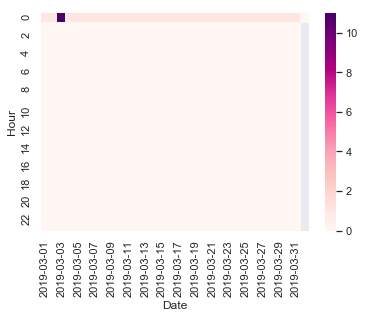

In [36]:
plot_heatmap_bot_detection(clean_frame,'raidenkeegan')

Looks like a bot, even though there is some change in eos transactions

In [40]:
new_list_of_bots.append('raidenkeegan')

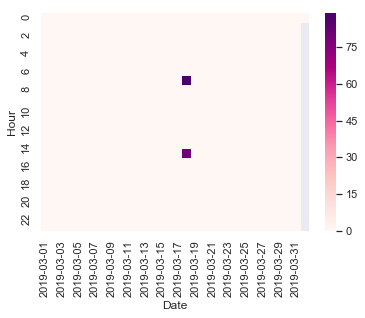

In [38]:
plot_heatmap_bot_detection(clean_frame,'ha2tqmjsgqge')

This is questionable, not quite sure, it could be a human or a bot. Althought its activity is random, it also has very high transaction counts in its active hours, which would seem unusual for a human.

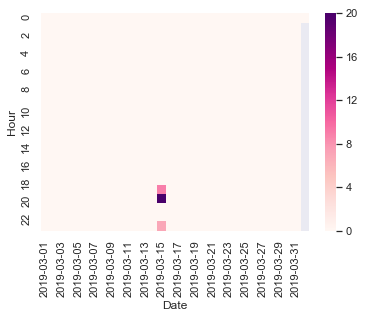

In [41]:
plot_heatmap_bot_detection(clean_frame,'bidream3idxx')

This for sure seems human. It has low txn count in the active hours and it is not very active.

In [42]:
new_list_of_huamns.append('bidream3idxx')

Let's make this process systematic. Since this dataset is human sparse. We will be undersampling for human labels in our dataset

In [9]:
listToClassify=data.sample(n=100, random_state=42, axis=0)['index']

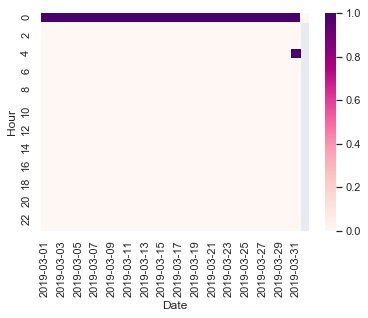

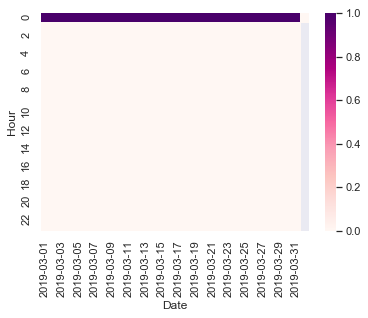

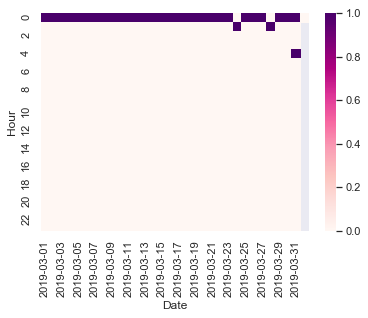

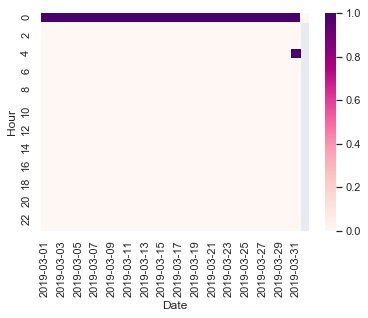

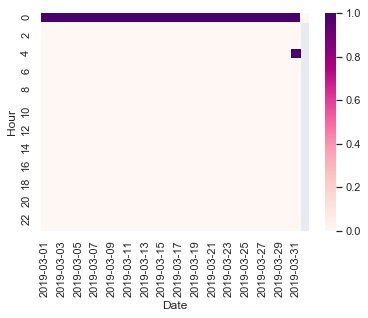

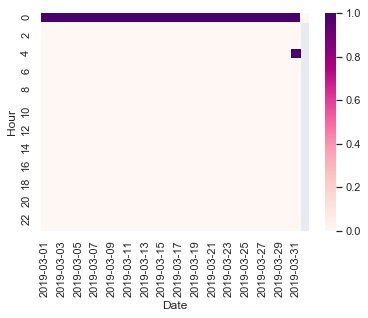

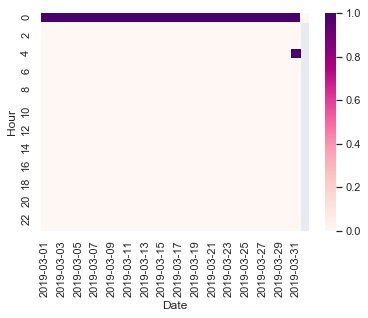

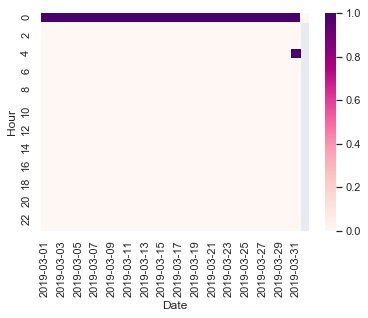

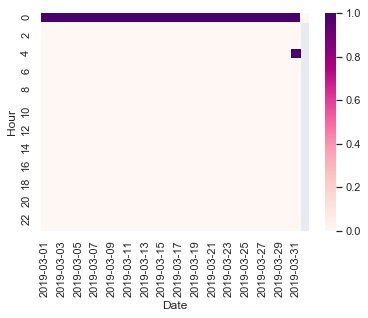

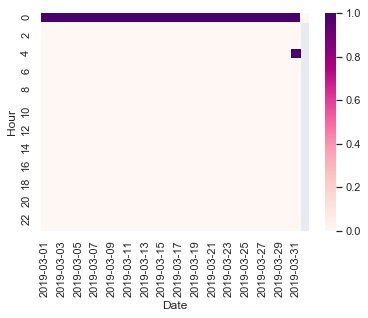

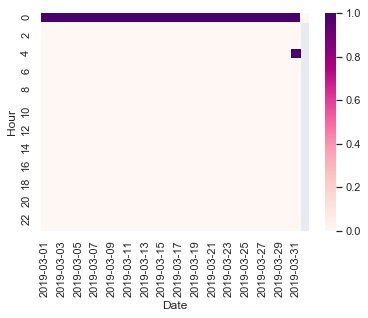

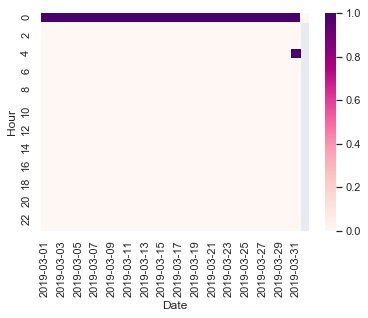

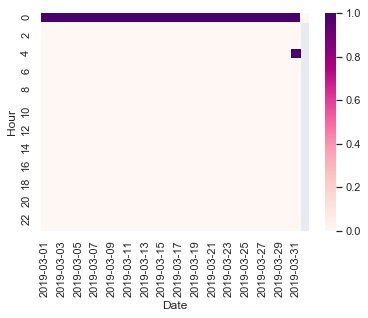

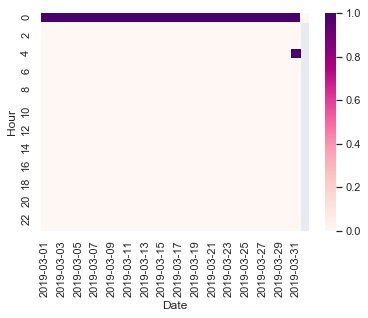

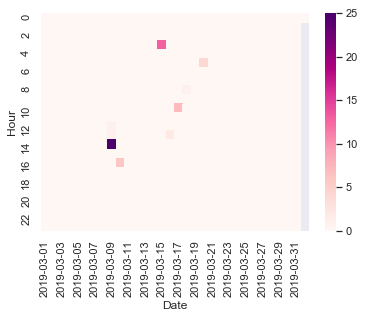

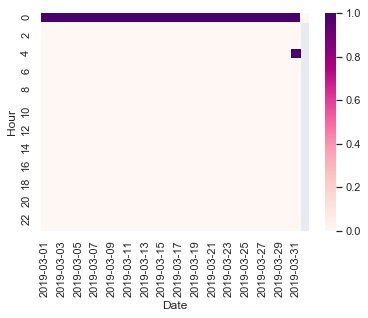

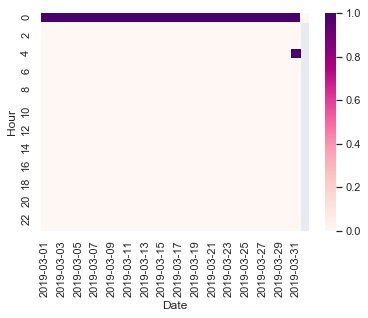

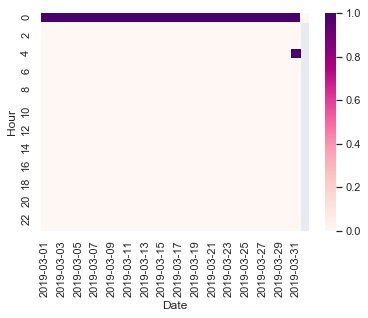

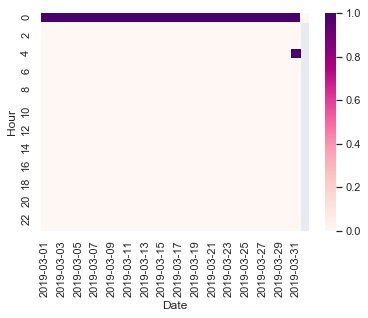

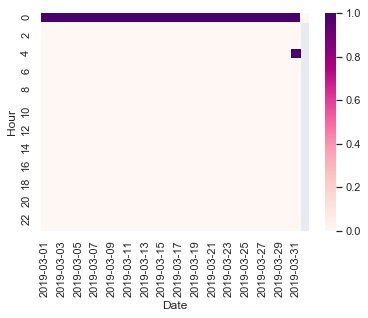

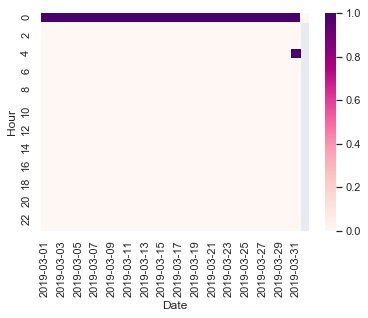

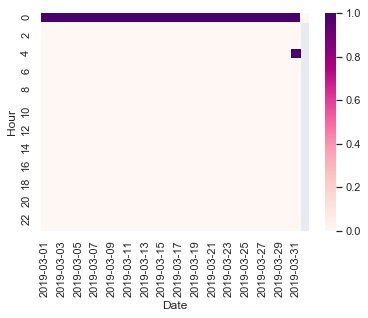

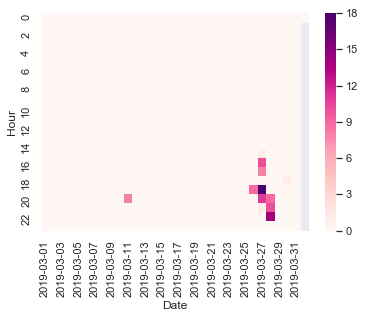

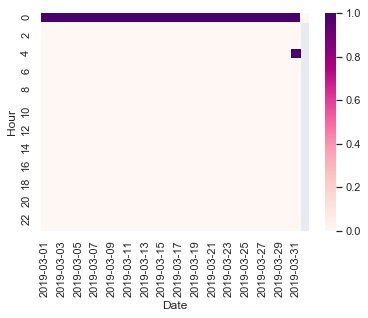

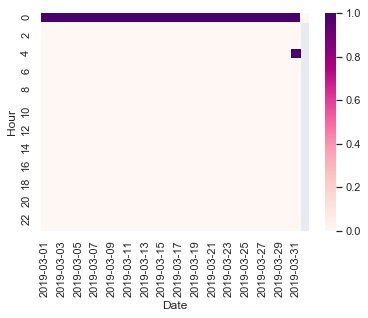

In [23]:
for x in listToClassify[:25]:
    plot_heatmap_bot_detection(frame,x)

In [ ]:
14,22

In [28]:
new_list_of_huamns.append(listToClassify[14:15])

In [30]:
new_list_of_huamns.append(listToClassify[22:23])

In [31]:
new_list_of_huamns

[Series([], Name: index, dtype: object), 1029    zengpaul1234
 Name: index, dtype: object, 997    luckylukeeos
 Name: index, dtype: object]

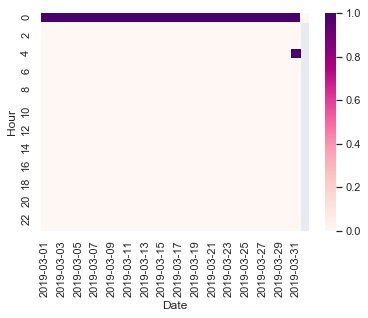

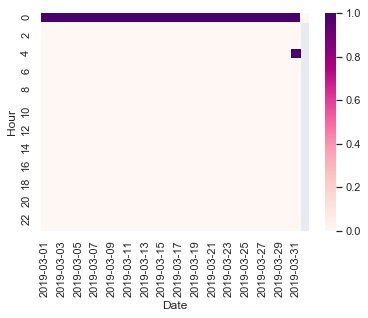

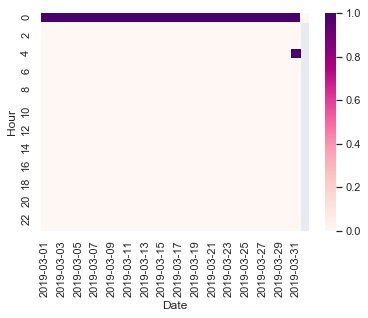

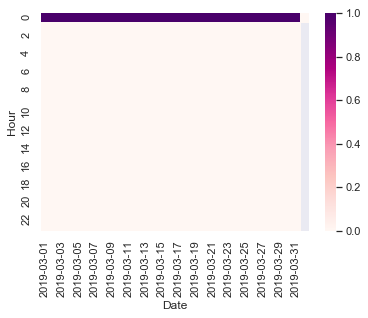

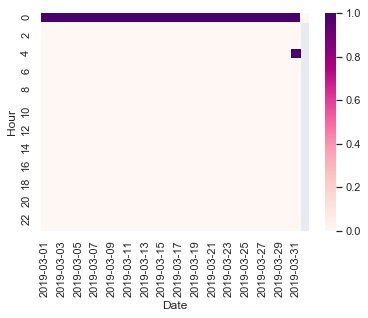

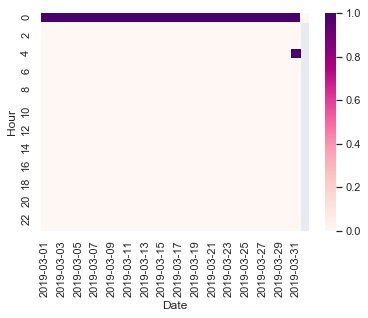

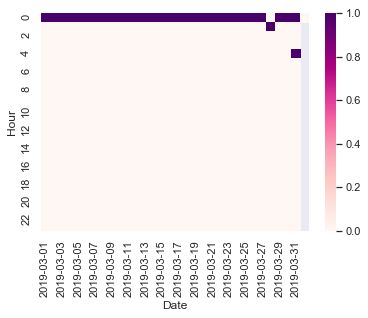

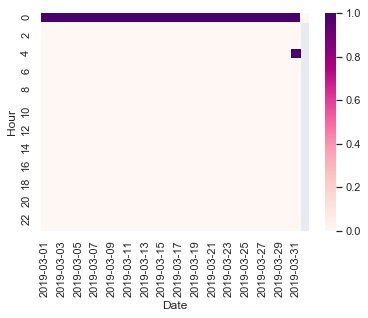

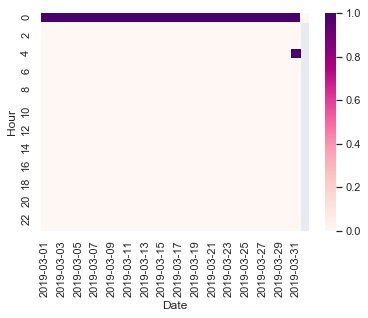

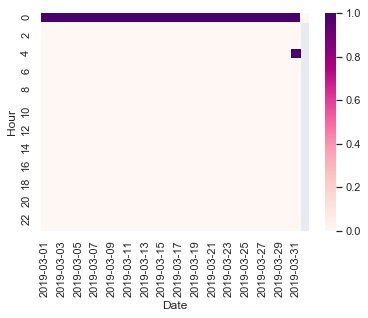

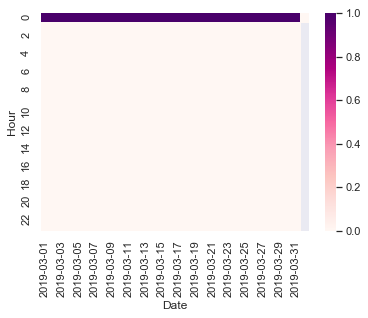

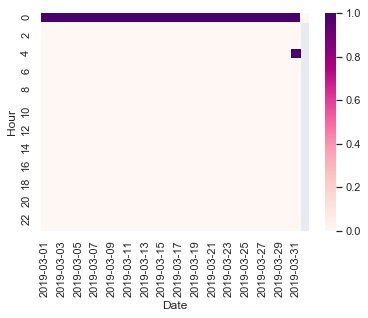

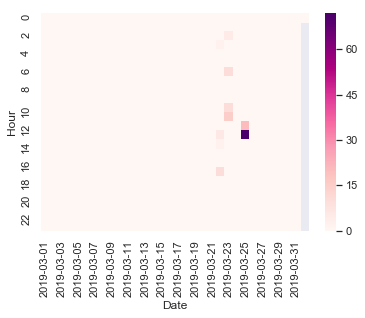

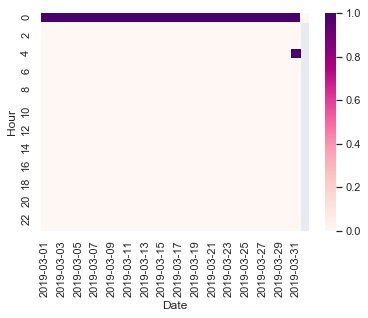

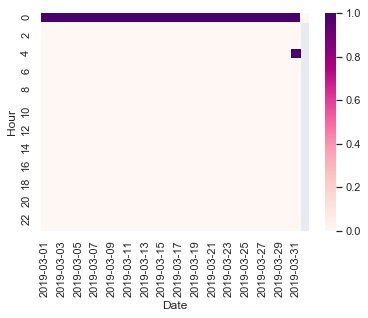

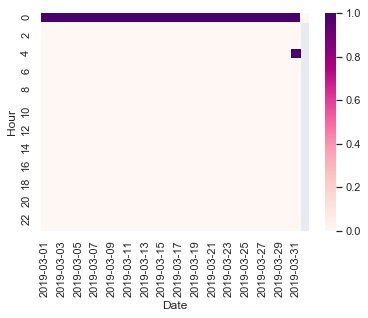

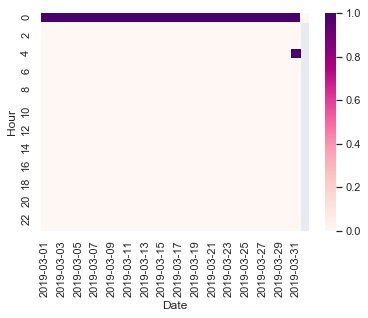

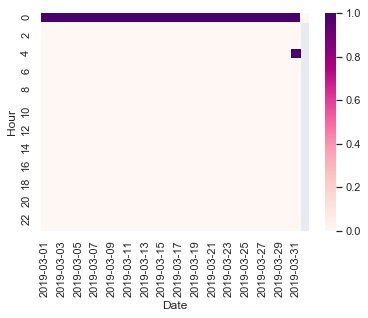

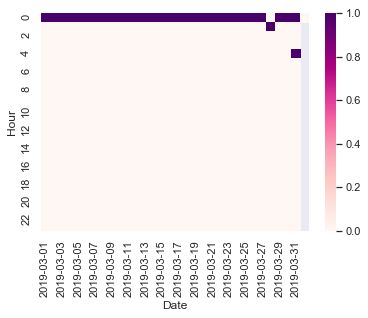

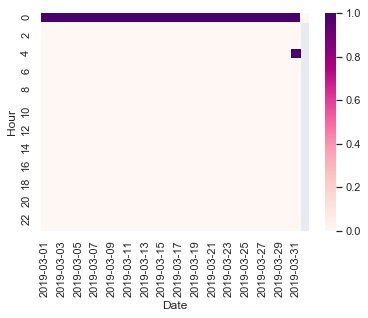

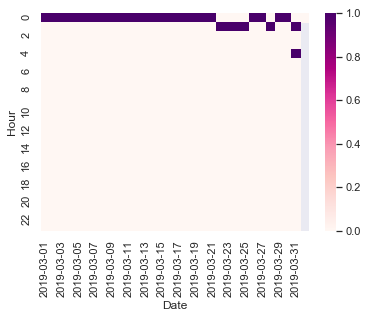

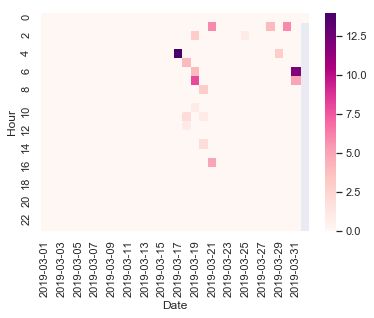

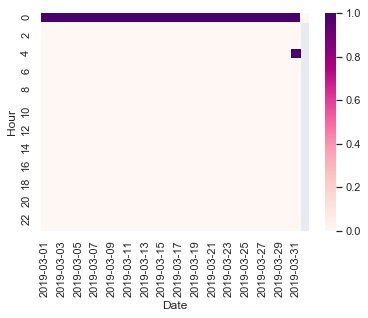

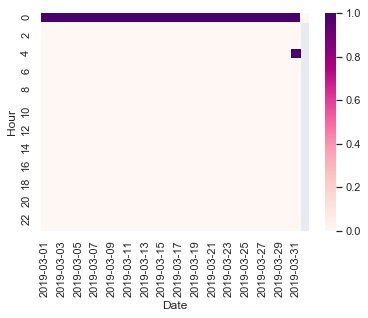

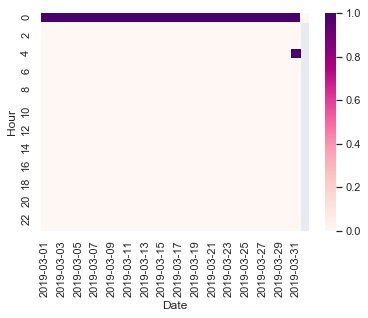

In [32]:
for x in listToClassify[25:50]:
    plot_heatmap_bot_detection(frame,x)

In [ ]:
37,46

In [33]:
new_list_of_huamns.append(listToClassify[37:38])

In [34]:
new_list_of_huamns.append(listToClassify[46:47])

In [35]:
new_list_of_huamns

[Series([], Name: index, dtype: object), 1029    zengpaul1234
 Name: index, dtype: object, 997    luckylukeeos
 Name: index, dtype: object, 1051    gi3dmnzyhege
 Name: index, dtype: object, 1001    cdlyxfkl5555
 Name: index, dtype: object]

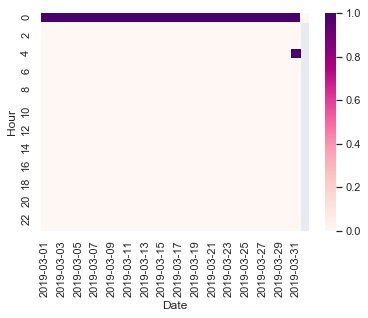

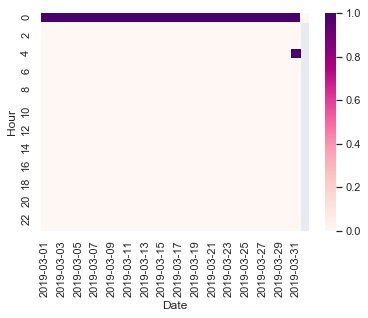

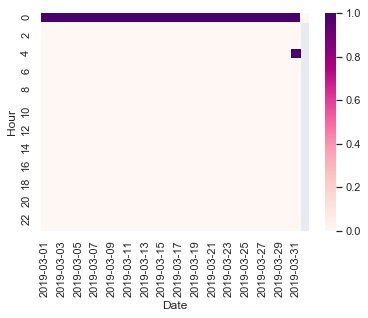

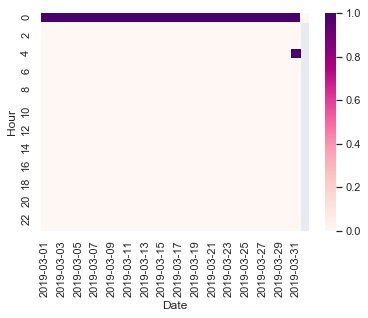

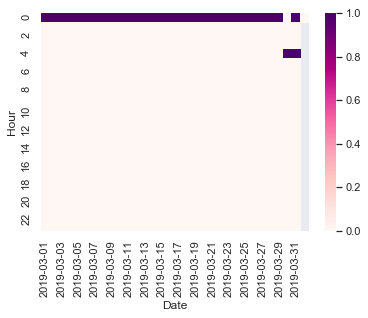

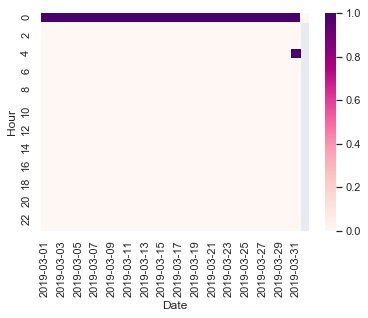

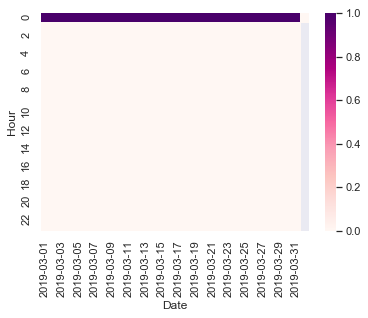

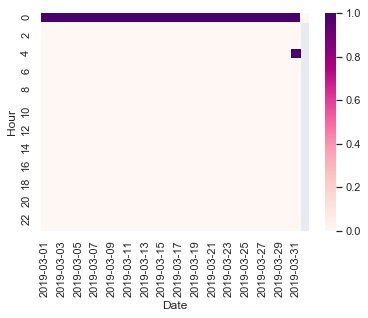

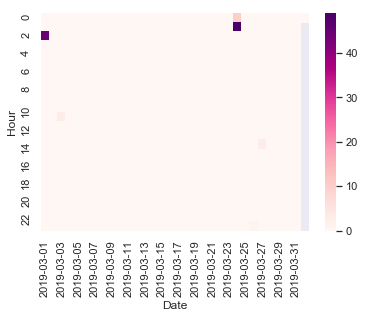

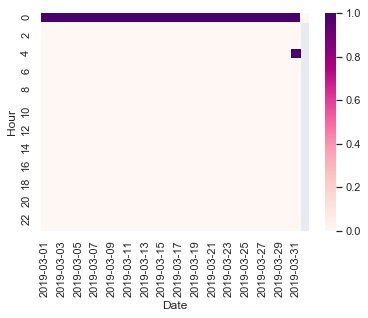

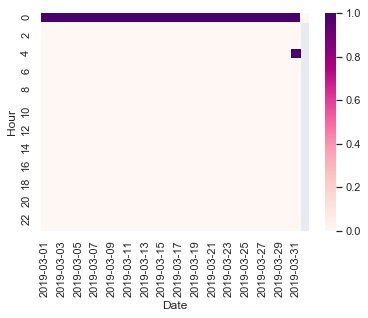

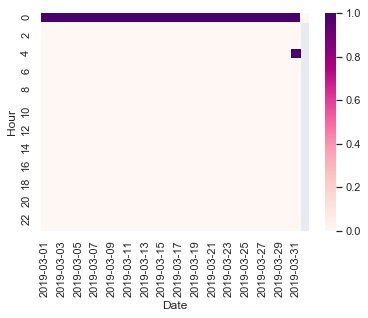

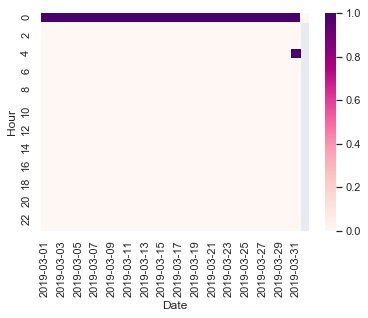

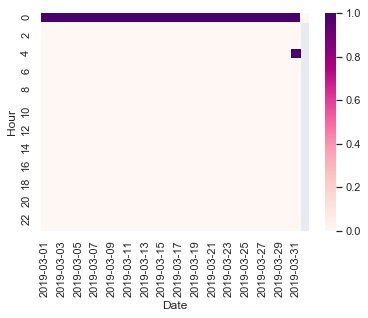

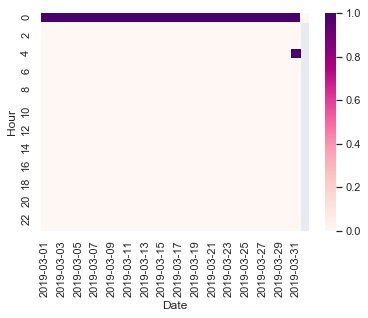

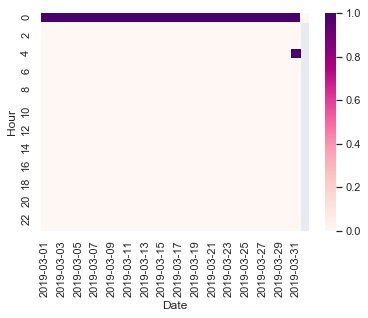

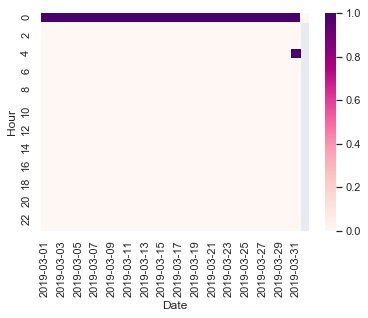

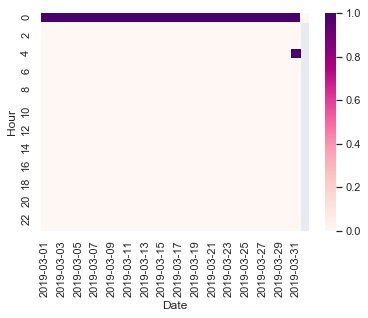

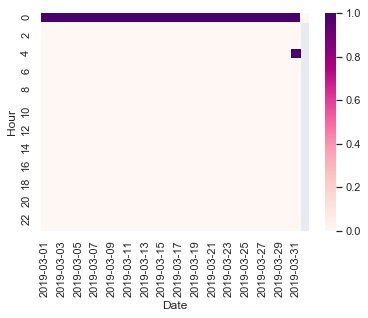

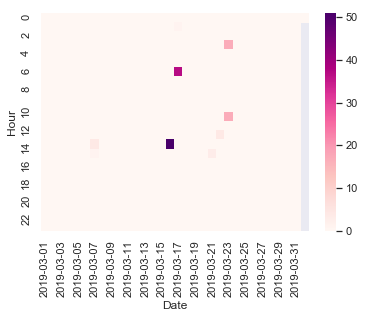

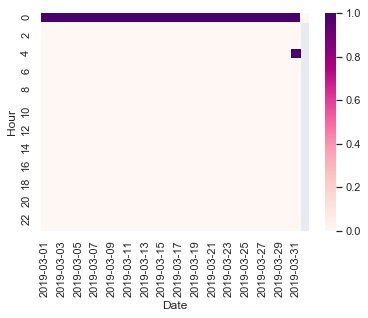

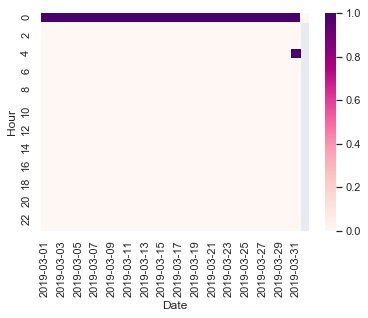

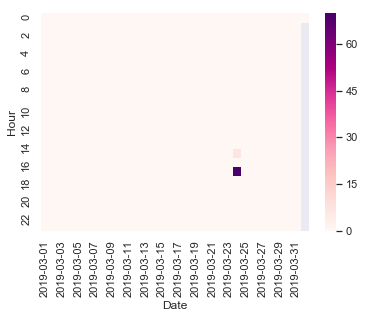

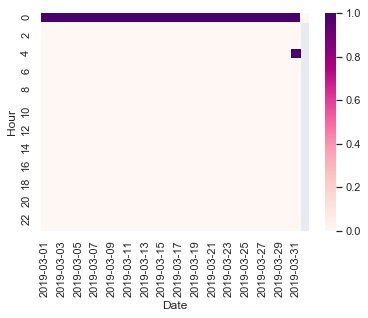

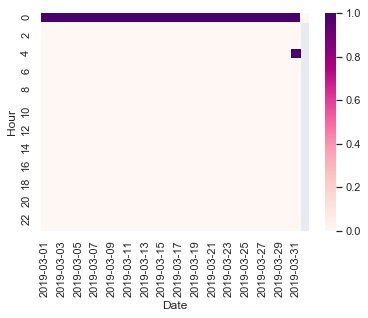

In [36]:
for x in listToClassify[50:75]:
    plot_heatmap_bot_detection(frame,x)

In [ ]:
72,69,58

In [40]:
listToClassify[58:59]

1013    g42tgmbshege
Name: index, dtype: object

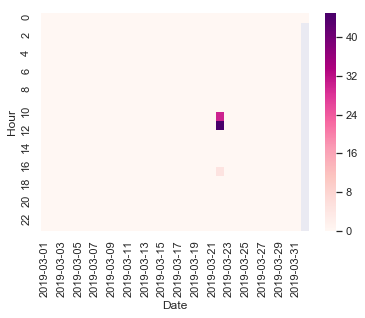

In [43]:
plot_heatmap_bot_detection(frame,'dongjh311eos')

In [53]:
data['maxAutoCorrelation']=[float(i) for i in data['maxAutoCorrelation']]

In [56]:
data[data['maxAutoCorrelation']>0.7]

,Unnamed: 0,index,maxAutoCorrelation,numberofTxns,stDevEosSent,numActiveDays,maxTxnsDay,minTxnsDay,avgTxnsPerActiveDays,numTxnsWeekdays,numTxnsWeekends,numActiveDaysWeekdays,numActiveWeekends,numActiveHours,maxTxnsHour,minTxnsHour,txnsPerActiveHour,numActiveHoursWeekdays,numActiveHoursWeekends
0,0,edgarwinston,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
2,2,heathderrick,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
3,3,jakobantoine,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
4,4,bryantjaylon,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
5,5,karsonskylar,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
6,6,luisclarence,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
7,7,griffinhamza,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
8,8,miguelmalaki,0.914547,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
9,9,devinbeckham,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5
10,10,sullivangael,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5


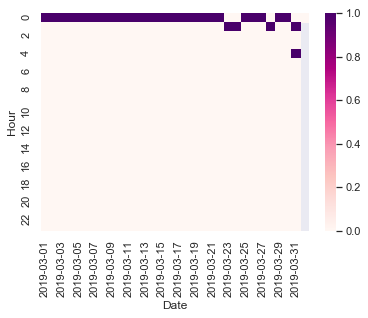

In [60]:
plot_heatmap_bot_detection(frame,'marqueskevin')

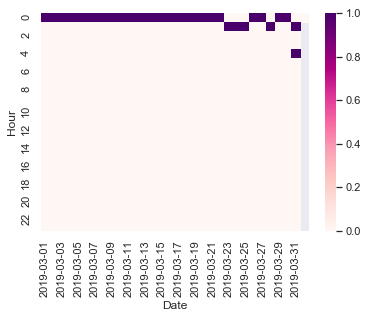

In [90]:
plot_heatmap_bot_detection(frame,'brentontyler')

Ultimately came up with these final labels

In [92]:
list_of_bots=['Edgarwinston','1ffyqhg4rmbk','nckj42dit5sb','heathderrick','yuremmichael','marqueskevin','zamucrnywhe2','miguelmalaki','eastonjorden','zamucrnywhe2','cryptodivid5','gizdmmrrgyge','raidenkeegan', 'cuizhi123451','jaggerjordan','hkxwbqhqm2v3','brentontyler','trystancaleb','yuremmichael']

In [93]:
list_of_humans=['Nakajoneso33','myhappyended','bidream3idxx','h4nne5eos231','bobo12341234','praabc123abc','gu4donzwguge', 'zengpaul1234','luckylukeeos', 'gi3dmnzyhege','cdlyxfkl5555','fuziondeveos','yazhououzhou','g42tgmbshege','dongjh311eos', 'paulingers12', 'gizdmmrrgyge','amiaoeos1234', 'gqydgmrrg4ge','amiaoeos1234']

In [94]:
len(list_of_bots)

19

In [95]:
len(list_of_humans)

20

Applying the labels

In [96]:
data['label'] = data.apply(lambda row: 1 if row['index'] in list_of_bots else
                                       (0 if row['index'] in list_of_humans else None), axis = 1) 

In [97]:
labeled_data=data[data['label'].notnull()]

In [100]:
labeled_data

,Unnamed: 0,index,maxAutoCorrelation,numberofTxns,stDevEosSent,numActiveDays,maxTxnsDay,minTxnsDay,avgTxnsPerActiveDays,numTxnsWeekdays,numTxnsWeekends,numActiveDaysWeekdays,numActiveWeekends,numActiveHours,maxTxnsHour,minTxnsHour,txnsPerActiveHour,numActiveHoursWeekdays,numActiveHoursWeekends,label
1,1,raidenkeegan,0.579704,41,3.864911e-01,31,11.0,0.0,1.322581,21.0,15.0,21,5,31,11.0,0.0,1.322581,21,5,1.0
2,2,heathderrick,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5,1.0
8,8,miguelmalaki,0.914547,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5,1.0
72,72,eastonjorden,0.938768,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,5.0,21,5,31,1.0,0.0,1.000000,21,5,1.0
489,489,zamucrnywhe2,0.938768,31,2.775558e-17,30,2.0,0.0,1.033333,20.0,6.0,20,5,31,1.0,0.0,1.000000,20,6,1.0
551,551,1ffyqhg4rmbk,0.966293,32,0.000000e+00,31,2.0,0.0,1.032258,21.0,6.0,21,5,32,1.0,0.0,1.000000,21,6,1.0
701,701,nckj42dit5sb,0.966293,32,0.000000e+00,31,2.0,0.0,1.032258,21.0,6.0,21,5,32,1.0,0.0,1.000000,21,6,1.0
948,948,hkxwbqhqm2v3,0.867254,32,0.000000e+00,31,2.0,0.0,1.032258,21.0,6.0,21,5,32,1.0,0.0,1.000000,21,6,1.0
964,964,jaggerjordan,0.829275,32,0.000000e+00,31,2.0,0.0,1.032258,21.0,6.0,21,5,32,1.0,0.0,1.000000,21,6,1.0
966,966,marqueskevin,0.829275,32,0.000000e+00,31,2.0,0.0,1.032258,21.0,6.0,21,5,32,1.0,0.0,1.000000,21,6,1.0


**We now have some labeled data**

# Semi-Supervised Label Spreading

In [99]:
labeled_data.shape

(33, 20)

Split our labeled_data into training features and labels

In [103]:
x_labeled=labeled_data.iloc[:,2:19]

In [105]:
y_labeled=labeled_data.iloc[:,19:20]

Scaled our data for the labelspreading since it is using knn as a kernel. We also have several outliers in our dataset, so robust scaler seemed most appropriate

In [106]:
from sklearn.preprocessing import RobustScaler

In [107]:
rs=RobustScaler()

Fit and transformed features with robust scaler

In [108]:
x_labeled_scaled=rs.fit_transform(x_labeled)

Initialize semi-supervised learning model

In [110]:
from sklearn import semi_supervised
ls=semi_supervised.LabelSpreading(kernel='knn')

In [112]:
ls.fit(x_labeled_scaled,y_labeled)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelSpreading(alpha=0.2, gamma=20, kernel='knn', max_iter=30, n_jobs=None,
        n_neighbors=7, tol=0.001)

In [114]:
x=data.iloc[:,2:19]

In [115]:
x_scaled=rs.transform(x)

Use label spreading to predict labels

In [116]:
pred_y=ls.predict(x_scaled)

In [117]:
data['pred_y']=pred_y

In [118]:
data

,Unnamed: 0,index,maxAutoCorrelation,numberofTxns,stDevEosSent,numActiveDays,maxTxnsDay,minTxnsDay,avgTxnsPerActiveDays,numTxnsWeekdays,...,numActiveDaysWeekdays,numActiveWeekends,numActiveHours,maxTxnsHour,minTxnsHour,txnsPerActiveHour,numActiveHoursWeekdays,numActiveHoursWeekends,label,pred_y
0,0,edgarwinston,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,...,21,5,31,1.0,0.0,1.000000,21,5,NaN,1.0
1,1,raidenkeegan,0.579704,41,3.864911e-01,31,11.0,0.0,1.322581,21.0,...,21,5,31,11.0,0.0,1.322581,21,5,1.0,0.0
2,2,heathderrick,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,...,21,5,31,1.0,0.0,1.000000,21,5,1.0,1.0
3,3,jakobantoine,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,...,21,5,31,1.0,0.0,1.000000,21,5,NaN,1.0
4,4,bryantjaylon,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,...,21,5,31,1.0,0.0,1.000000,21,5,NaN,1.0
5,5,karsonskylar,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,...,21,5,31,1.0,0.0,1.000000,21,5,NaN,1.0
6,6,luisclarence,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,...,21,5,31,1.0,0.0,1.000000,21,5,NaN,1.0
7,7,griffinhamza,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,...,21,5,31,1.0,0.0,1.000000,21,5,NaN,1.0
8,8,miguelmalaki,0.914547,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,...,21,5,31,1.0,0.0,1.000000,21,5,1.0,1.0
9,9,devinbeckham,0.983027,31,2.775558e-17,31,1.0,0.0,1.000000,21.0,...,21,5,31,1.0,0.0,1.000000,21,5,NaN,1.0


Are there any data points which were missclassified by our semi-supervised model?

In [128]:
notNull=data[data['label'].notnull()]

In [131]:
notNull[notNull['label']!=notNull['pred_y']]

,Unnamed: 0,index,maxAutoCorrelation,numberofTxns,stDevEosSent,numActiveDays,maxTxnsDay,minTxnsDay,avgTxnsPerActiveDays,numTxnsWeekdays,...,numActiveDaysWeekdays,numActiveWeekends,numActiveHours,maxTxnsHour,minTxnsHour,txnsPerActiveHour,numActiveHoursWeekdays,numActiveHoursWeekends,label,pred_y
1,1,raidenkeegan,0.579704,41,3.864911e-01,31,11.0,0.0,1.322581,21.0,...,21,5,31,11.0,0.0,1.322581,21,5,1.0,0.0
489,489,zamucrnywhe2,0.938768,31,2.775558e-17,30,2.0,0.0,1.033333,20.0,...,20,5,31,1.0,0.0,1.000000,20,6,1.0,0.0
994,994,cuizhi123451,0.485456,34,5.230557e-01,28,2.0,0.0,1.214286,25.0,...,20,4,33,2.0,0.0,1.030303,24,5,1.0,0.0
1052,1052,gizdmmrrgyge,0.473178,31,2.775558e-17,2,18.0,0.0,15.500000,13.0,...,1,0,2,18.0,0.0,15.500000,1,0,1.0,0.0


Yup four were misclassified and it seems they have low transaction count and have some simple activities. We would definitely want to improve on this label spreading in the future.

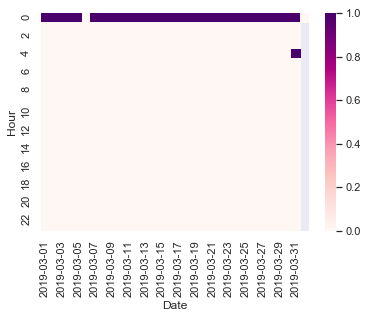

In [132]:
plot_heatmap_bot_detection(frame,'zamucrnywhe2')

In [134]:
data.to_csv('../Data/pseudolabeleddata.csv')

Pseudolabeled_data is outputed ready for supervised learning